## Workflow: Pumping test model (Theis1)

We consider a pumping test in a confined aquifer or fracture 
(the Theis problem). In the famous analytical solution by Theis, 
the aquifer/fracture is assumed to be infinitely extended and 
the pumping well is represented by a point injection/extraction. 
For the numerical analysis, however, we consider a square 
aquifer/fracture with a pumping well at its centre.
        
We conduct the following workflow steps:
- Model geometry (`gml` file)
- Meshing (`gmsh`)
- Create OGS project (`prj` file)
- Material properties
- Boundary conditions
- Run simulation (`ogs`)
- Plot results

### Model geometry (`gml` file)

The following example of XML file shows the geometry definition 
for the pumping well in a square (aquifer/fracture).
The `gml` file (`theis1.gml`) must be available before simulation
for defining the boundary conditions.

```
<?xml version="1.0" encoding="ISO-8859-1"?>
<?xml-stylesheet type="text/xsl" href="OpenGeoSysGLI.xsl"?>
<OpenGeoSysGLI xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:ogs="http://www.opengeosys.org">
    <name>h-testing</name>
    <points>
        <point id="0" x="-50.0" y="-50.0" z="0" name="inflow"/>
        <point id="1" x="50.0" y="-50.0" z="0"/>
        <point id="2" x="50.0" y="50.0" z="0" name="outflow"/>
        <point id="3" x="-50.0"  y="50.0" z="0"/>
        <point id="4" x="0"  y="0" z="0" name="well"/>
    </points>
    <polylines>
        <polyline id="0" name="left">
            <pnt>0</pnt>
            <pnt>3</pnt>
        </polyline>		
        <polyline id="1" name="right">
            <pnt>1</pnt>
            <pnt>2</pnt>
        </polyline>		
        <polyline id="2" name="boundary">
            <pnt>0</pnt>
            <pnt>1</pnt>
            <pnt>2</pnt>
            <pnt>3</pnt>
        </polyline>	
    </polylines>
</OpenGeoSysGLI>
```

### Meshing

We are using the `gmsh` API for generating the mesh for simulation.

In [7]:
import gmsh
import sys
import pyvista as pv
###########################################################
#1: meshing GEO > MSH > VTK
gmsh.initialize(sys.argv)
gmsh.model.add("square_with_inner_point")
# ===========================================================
# Define geometries
# mesh size
lc = 5
lp = 1
# 4 points for the outer square
p1 = gmsh.model.geo.addPoint(-50, -50, 0, lc)
p2 = gmsh.model.geo.addPoint( 50, -50, 0, lc)
p3 = gmsh.model.geo.addPoint( 50,  50, 0, lc)
p4 = gmsh.model.geo.addPoint(-50,  50, 0, lc)
# inner point
inner_point_tag = gmsh.model.geo.addPoint(0, 0, 0, lp) # Point at origin
# create lines and surface
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)
curve_loop = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])
surface_tag = gmsh.model.geo.addPlaneSurface([curve_loop])
# sync before embedding
gmsh.model.geo.synchronize()
# embed the inner point into the surface
# this forces a mesh node at the exact coordinate
gmsh.model.mesh.embed(0, [inner_point_tag], 2, surface_tag)
# ===========================================================
# Generate 2D mesh and save
gmsh.model.mesh.generate(2)
# get all elements in the model
elementTypes, elementTags, nodeTags = gmsh.model.mesh.getElements()
print("Element types present after generation:", elementTypes)
# Type 15 = Point (Vertex), Type 1 = Line, Type 2 = Triangle
# ===========================================================
gmsh.write("square_with_center_node.msh")
gmsh.write("square_with_center_node.vtk")
# uncomment to view the result
##gmsh.fltk.run()
gmsh.finalize()
# convert VTK to VTU
mesh = pv.read('square_with_center_node.vtk')
mesh.save('square_with_center_node.vtu')
# get mesh information
print(f"Number of points: {mesh.n_points}")
print(f"Number of cells: {mesh.n_cells}")

Element types present after generation: [ 1  2 15]
Number of points: 939
Number of cells: 1881


We need an additional step to remove (0-dimensional) 
vertex elements.

In [8]:
import pyvista as pv
# Load the mesh with the central vertex
mesh = pv.read('square_with_center_node.vtu')
# Create a mask to select only cells that are NOT vertices (type != 1)
# This removes the central point cell but keeps the surface/volume elements
non_vertex_mask = mesh.celltypes != 1
# Apply the mask to extract the desired cells
mesh_without_vertex_cells = mesh.extract_cells(non_vertex_mask)
# Save the clean mesh
mesh_without_vertex_cells.save('theis1.vtu')
print(f"Removed vertex cells. New cell count: {mesh_without_vertex_cells.n_cells}")


Removed vertex cells. New cell count: 1876


### Create OGS project (`prj` file)

In [9]:
import ogstools as ot
###########################################################
# project creation PRJ for H process
# Dirichlet boundary condition in the central point
def prj_create_H_process(filename):
    #processes
    prj_file = f"{filename}{".prj"}"
    gml_file = f"{filename}{".gml"}"
    vtu_file = f"{filename}{".vtu"}"
    #
    prj = ot.Project(output_file=prj_file)
    prj.geometry.add_geometry(filename=gml_file)
    prj.mesh.add_mesh(filename=vtu_file)
    prj.processes.set_process(
        name="LiquidFlow",
        type="LIQUID_FLOW",
        integration_order="2",
        specific_body_force="0 0",
    )
    prj.processes.add_process_variable(
        process_variable="process_variable", process_variable_name="pressure"
    )
    prj.processes.add_secondary_variable(internal_name="darcy_velocity", output_name="velocity")
    #medium properties
    #medium0
    prj.media.add_property(
        medium_id="0", phase_type="AqueousLiquid", name="density", type="Constant", value="1000",
    )
    prj.media.add_property(
        medium_id="0", phase_type="AqueousLiquid", name="viscosity", type="Constant", value="1e-3",
    )
    prj.media.add_property(
        medium_id="0", name="porosity", type="Constant", value="1.0",
    )
    prj.media.add_property(
        medium_id="0", name="permeability", type="Constant", value="1e-13",
    )
    prj.media.add_property(
        medium_id="0", name="reference_temperature", type="Constant", value="293.15",
    )
    prj.media.add_property(
        medium_id="0", name="storage", type="Constant", value="1e-6",
    )
    #parameters
    prj.parameters.add_parameter(name="p0", type="Constant", value="0")
    prj.parameters.add_parameter(name="p_well", type="Constant", value="1e6")
    prj.parameters.add_parameter(name="constant_porosity_parameter", type="Constant", value="1")
    prj.parameters.add_parameter(name="kappa1", type="Constant", value="1e-3")
    #initial and boundary conditions
    prj.process_variables.set_ic(
        process_variable_name="pressure", components="1", order="1", initial_condition="p0",
    )
    prj.process_variables.add_bc(
        process_variable_name="pressure", components="1", geometrical_set="h-testing", geometry="well", type="Dirichlet", parameter="p_well",
    )
    #solver
    prj.nonlinear_solvers.add_non_lin_solver(
        name="basic_picard", type="Picard", max_iter="10", linear_solver="general_linear_solver",
    )
    prj.linear_solvers.add_lin_solver(
        name="general_linear_solver",
        kind="lis",
        solver_type="cg",
        precon_type="jacobi",
        max_iteration_step="10000",
        error_tolerance="1e-20",
    )
    prj.linear_solvers.add_lin_solver(
        name="general_linear_solver",
        kind="eigen",
        solver_type="CG",
        precon_type="DIAGONAL",
        max_iteration_step="10000",
        error_tolerance="1e-20",
    )
    prj.linear_solvers.add_lin_solver(
        name="general_linear_solver",
        kind="petsc",
        prefix="lf",
        solver_type="cg",
        precon_type="bjacobi",
        max_iteration_step="10000",
        error_tolerance="1e-16",
    )
    #time loop
    prj.time_loop.add_process(
        process="LiquidFlow",
        nonlinear_solver_name="basic_picard",
        convergence_type="DeltaX",
        norm_type="NORM2",
        time_discretization="BackwardEuler",
        abstol="1e-6"
    )
    prj.time_loop.set_stepping(
        process="LiquidFlow",
        type="FixedTimeStepping",
        t_initial="0.0",
        t_end="86400000 ",
        repeat="1",
        delta_t="864000",
    )
    #output
    prj.time_loop.add_output(
        type="VTK",
        prefix=filename,
        repeat="1",
        each_steps="10",
        variables=["pressure", "velocity"],
    )
    #
    prj.write_input()

# call function
prj_create_H_process('theis1')

### Run simulation

In [10]:
import os
import ogstools as ot
from pathlib import Path
###########################################################
prj_file = "theis1.prj"
out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)
model = ot.Project(input_file=prj_file, output_file=f"{out_dir}/modified.prj")
model.write_input()
model.run_model(logfile=f"{out_dir}/out.txt", args=f"-o {out_dir} -m . -s .")


Project file written to output.
Simulation: _out\modified.prj
Status: finished successfully.
Execution took 3.0190212726593018 s


### Plot results
#### Profile along central line (-50,0,0) (50,0,0)

[       0.  8640000. 17280000. 25920000. 34560000. 43200000. 51840000.
 60480000. 69120000. 77760000. 86400000.]


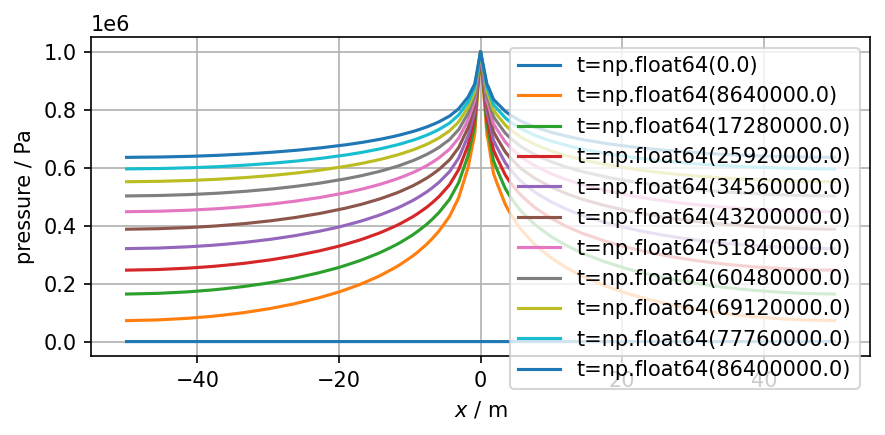

In [11]:
import ogstools as ot
import matplotlib.pyplot as plt
import numpy as np

ms = ot.MeshSeries("_out/theis1.pvd")
print(ms.timevalues)

def plot_sample(var: ot.variables.Scalar) -> None:
    fig, ax = plt.subplots(figsize=[6, 3], dpi=150)
    ax.set_xlabel(r"$x$ / m")
    ax.set_ylabel(var.get_label())
    for mesh, t in zip(ms, ms.timevalues, strict=True):
        line_mesh = mesh.sample_over_line([-50, 0, 0], [50, 0, 0])
        vals = line_mesh.sample(mesh)[var.data_name]
        #assert np.all(np.abs(vals) <= max_vals[var.data_name]), max(abs(vals))
        ax.plot(line_mesh.points[:, 0], var.transform(vals), label=f"{t=}", lw=1.5)
    ax.legend()
    ax.grid()
    fig.tight_layout()
    plt.show()

plot_sample(ot.variables.Scalar("pressure", "Pa", "Pa"))


#### Plot over time at point

[       0.  8640000. 17280000. 25920000. 34560000. 43200000. 51840000.
 60480000. 69120000. 77760000. 86400000.]


100%|█████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 147.99it/s]


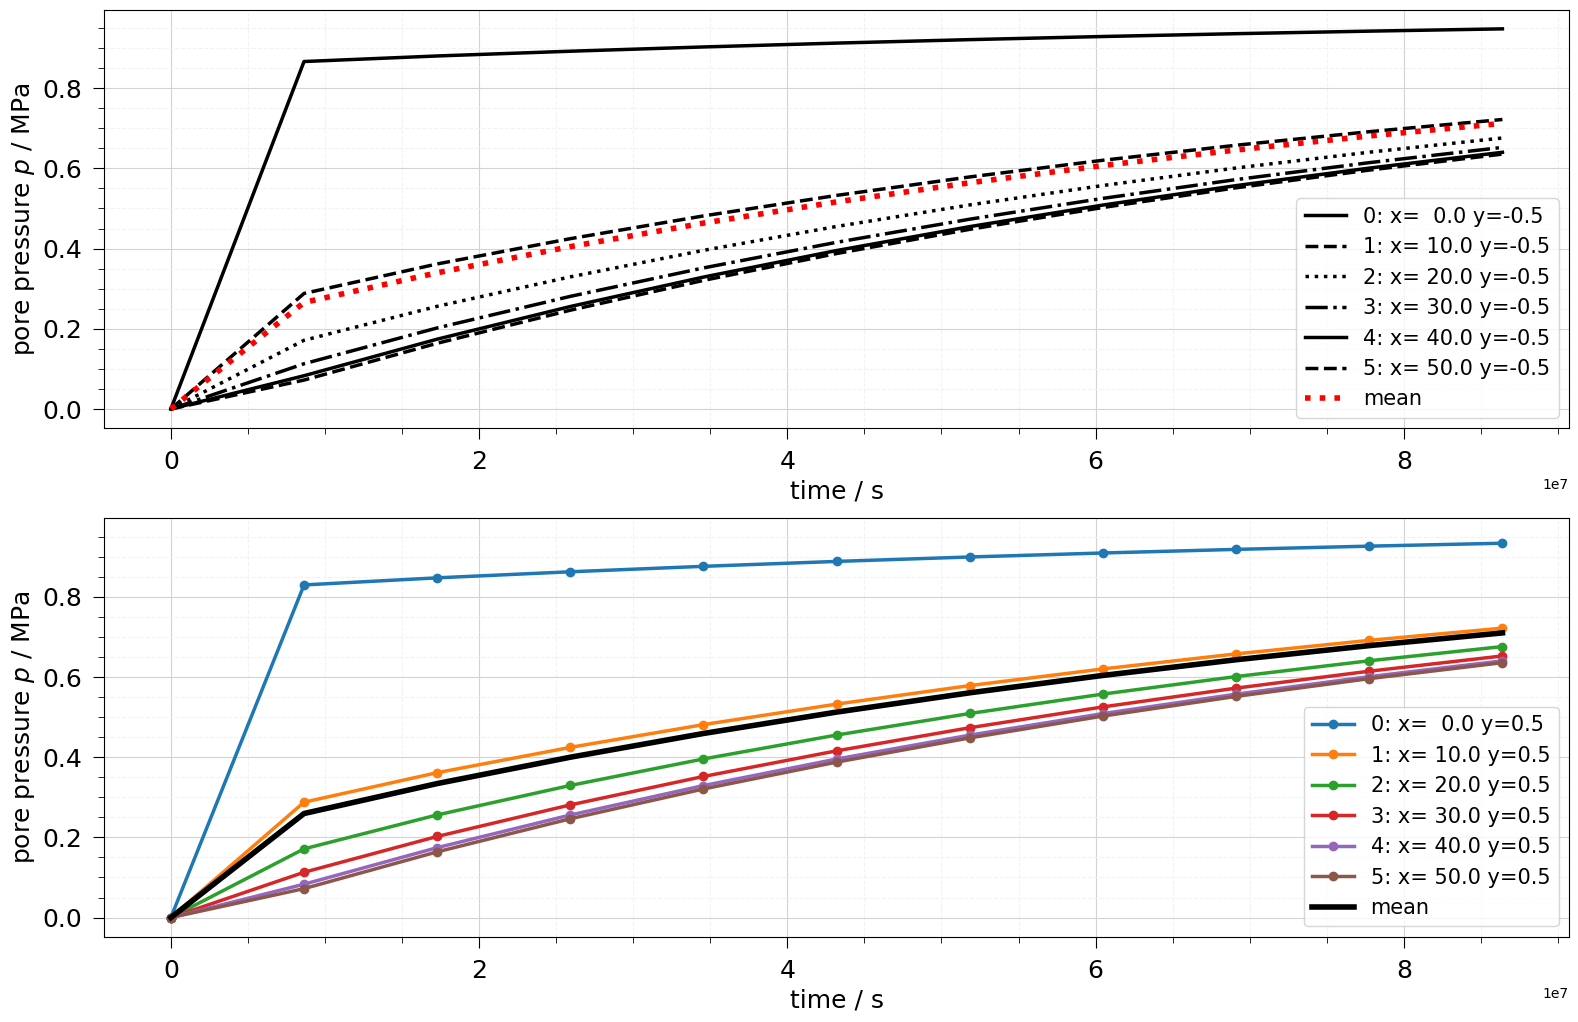

In [12]:
import ogstools as ot
import matplotlib.pyplot as plt
import numpy as np

mesh_series = ot.MeshSeries("_out/theis1.pvd")
print(mesh_series.timevalues)
pressure = ot.variables.pressure

rows = np.array([np.linspace([0, y, 0], [50, y, 0], 6) for y in [-0.5, 0.5]])
ms_pts = [ot.MeshSeries.extract_probe(mesh_series, pts) for pts in rows]
labels = [
    [f"{i}: x={pt[0]: >5} y={pt[1]}" for i, pt in enumerate(pts)]
    for pts in rows
]

fig, axs = plt.subplots(nrows=2, figsize=[16, 10], sharey=True)
ot.plot.line(ms_pts[0], "time", pressure, ax=axs[0], color="k", fontsize=18)
ot.plot.line(ms_pts[1], "time", pressure, ax=axs[1], marker="o", fontsize=18)
# add the mean of the observation point timeseries
for index in range(2):
    values = pressure.transform(ms_pts[index])
    mean_values = np.mean((values), axis=-1)
    ts = ms_pts[index].timevalues
    fig.axes[index].plot(ts, mean_values, "rk"[index], lw=4)
    fig.axes[index].legend(labels[index] + ["mean"], fontsize=15)
    
plt.show()

## Fine